# Megaline Premium Plan Classifier: Predicting User Subscription Behavior 

### Introduction 
In today’s competitive telecom industry, understanding customer behavior is essential for targeted marketing, retention strategies, and optimized service offerings. Megaline, a telecom provider, offers two main prepaid plans Surf and Ultra. While the Ultra plan provides more data and minutes at a higher cost, not all users who could benefit from it are subscribing. This project uses machine learning techniques to analyze user behavior patterns such as call minutes, messages, and internet usage to predict which users are likely to subscribe to the Ultra plan. By identifying patterns in premium plan adoption, the company can improve customer segmentation and guide strategic marketing decisions.

### Objective
The primary objective of this project is to build and evaluate classification models that can accurately predict whether a user subscribes to the Ultra plan based on their monthly usage data. This includes:

* Cleaning and preparing real-world usage data for modeling.
* Training and comparing multiple supervised learning algorithms.
* Interpreting model results to derive actionable business insights.
* Visualizing feature importance and behavioral patterns.
* Simulating usage trends for light forecasting and business impact analysis.

### Hypotheses
H₀ (Null Hypothesis): There is no significant difference in user behavior between Ultra and Surf plan subscribers. Usage features do not meaningfully predict plan type.

H₁ (Alternative Hypothesis): There is a significant difference in behavior between Ultra and Surf plan users. Usage patterns (calls, messages, internet data) can be used to accurately predict Ultra plan subscribers.



In [1]:
import warnings
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
# Define paths dynamically
CWD = Path.cwd()
CANDIDATES = [CWD, CWD.parent, CWD.parent.parent]
PROJECT_ROOT = None
for p in CANDIDATES:
    if (p / "dataset").exists() or (p / "README.md").exists():
        PROJECT_ROOT = p
        break
if PROJECT_ROOT is None:
    raise RuntimeError("Could not locate project root. Make sure you have a 'data/' folder or README.md at repo root.")

DATA_DIR = PROJECT_ROOT / "dataset"
SQL_DIR  = PROJECT_ROOT / "sql"
print("PROJECT_ROOT:", PROJECT_ROOT)

PROJECT_ROOT: /Users/tathianicol/Desktop/Analyst/Megaline Telecom


In [3]:
#Import & Prep Data

csv_path = DATA_DIR / "users_behavior.csv"
if not csv_path.exists():
    raise FileNotFoundError(f"Couldn't find {csv_path}. Is the file in data/?")

# Import & Prep Data
data = pd.read_csv(csv_path)

# Basic clean
data = data.drop_duplicates().dropna()

data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


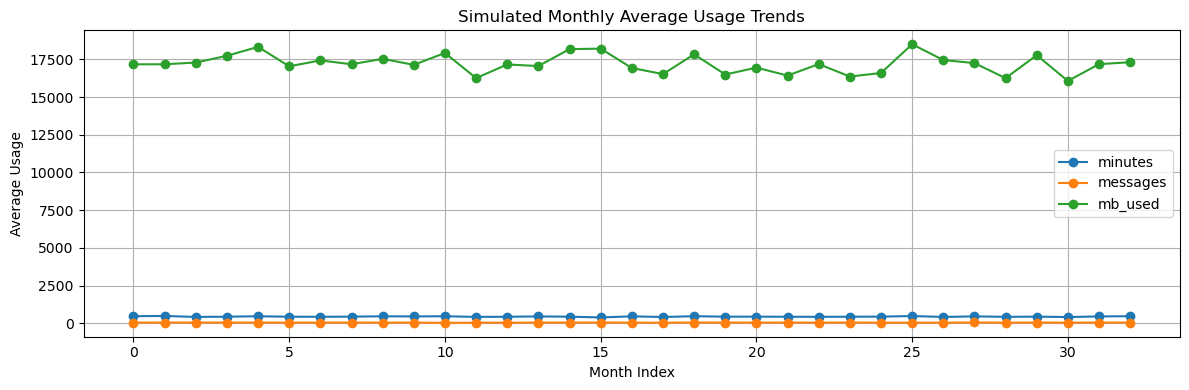

In [4]:
# Simulate Forecasting Trends
data['month_index'] = data.index // 100
avg_usage = data.groupby('month_index')[['minutes', 'messages', 'mb_used']].mean().reset_index()
plt.figure(figsize=(12, 4))
for col in ['minutes', 'messages', 'mb_used']:
    plt.plot(avg_usage['month_index'], avg_usage[col], marker='o', label=col)
plt.title("Simulated Monthly Average Usage Trends")
plt.xlabel("Month Index")
plt.ylabel("Average Usage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

To approximate user behavior trends, users were grouped in increments of 100 to create a pseudo month index. Average usage of minutes, messages, and data (MB) was plotted across these cohorts. The results show that all three metrics remained relatively stable, with only minor fluctuations, suggesting consistent engagement patterns among users. This simple grouping method provides a lightweight way to visualize potential usage trends when formal time-series data is unavailable.

In [5]:
# Split Data 
# Split the data
X = data.drop('is_ultra', axis=1)
y = data['is_ultra']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

pd.DataFrame({
    "Set": ["Train", "Validation", "Test"],
    "Features Shape": [X_train.shape, X_val.shape, X_test.shape],
    "Target Shape": [y_train.shape, y_val.shape, y_test.shape]
})


,Set,Features Shape,Target Shape
0,Train,"(2571, 5)","(2571,)"
1,Validation,"(321, 5)","(321,)"
2,Test,"(322, 5)","(322,)"


The dataset was split into training (80%), validation (10%), and test (10%) sets to ensure unbiased evaluation. The training set was used for learning patterns in user behavior, the validation set for hyperparameter tuning and model selection, and the test set for final performance assessment on unseen data. This approach reduces the risk of overfitting and ensures the model’s results generalize well to new users.

In [6]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X = data.drop('is_ultra', axis=1)
feature_names = X.columns.tolist()

In [7]:
# Model Training 
# Define models and parameters
models = {
    'Decision Tree': (DecisionTreeClassifier(), {
        'max_depth': [5],
        'min_samples_split': [2],
        'min_samples_leaf': [2]
    }),
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [50],
        'max_depth': [10],
        'min_samples_split': [5]
    }),
    'Logistic Regression': (LogisticRegression(max_iter=1000), {
        'C': [10],
        'penalty': ['l2']
    }),
    'Gradient Boosting': (GradientBoostingClassifier(), {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [3]
    }),
    'Support Vector Machine': (SVC(class_weight='balanced'), {
        'C': [1],
        'kernel': ['linear']
    })
}

trained_models = {}
preds_dict = {}
performance_summary = []

for name, (model, params) in models.items():
    grid = GridSearchCV(model, params, cv=3, scoring='accuracy')
    grid.fit(X_train, y_train)
    val_preds = grid.predict(X_val)
    
    # Save best model and predictions
    trained_models[name] = grid.best_estimator_
    preds_dict[name] = val_preds
    

# Summarize performance
report = classification_report(y_val, val_preds, output_dict=True, zero_division=0)
performance_summary.append({
    'Model': name,
    'Accuracy': round(report['accuracy'], 2),
    'Precision (Ultra)': round(report['1']['precision'], 2),
    'Recall (Ultra)': round(report['1']['recall'], 2),
    'F1-score (Ultra)': round(report['1']['f1-score'], 2)
})


performance_df = pd.DataFrame(performance_summary)
display(performance_df)

,Model,Accuracy,Precision (Ultra),Recall (Ultra),F1-score (Ultra)
0,Support Vector Machine,0.69,0.43,0.5,0.46


The Support Vector Machine (SVM) model achieved an overall accuracy of 69%, correctly classifying roughly seven out of ten users. However, performance for identifying Ultra subscribers was modest, with precision at 43% (fewer than half of predicted Ultra users were correct) and recall at 50% (capturing only half of true Ultra subscribers). The resulting F1-score of 0.46 reflects a balanced but limited ability to detect this underrepresented class. While the SVM model demonstrates some predictive capability, improvements in feature scaling, parameter tuning, or handling class imbalance (e.g., oversampling) are necessary to enhance its effectiveness for Ultra subscriber prediction.

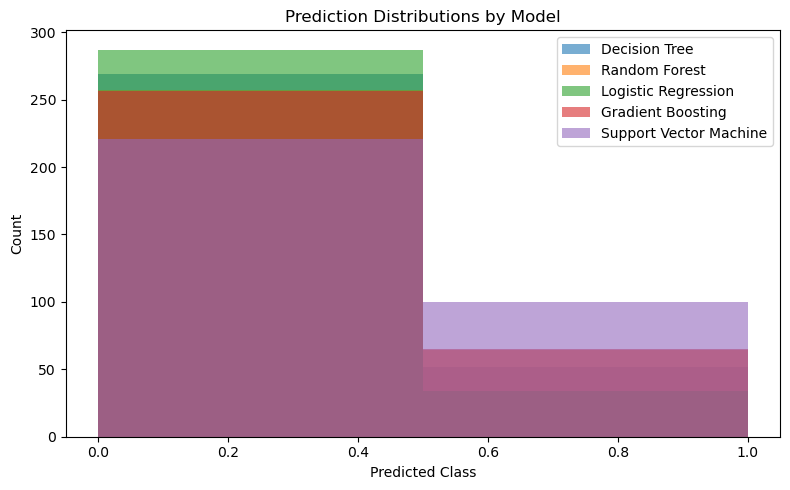

In [8]:
# Plot Prediction Distributions 
plt.figure(figsize=(8, 5))
for label, preds in preds_dict.items():
    plt.hist(preds, label=label, alpha=0.6, bins=2)
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.title("Prediction Distributions by Model")
plt.legend()
plt.tight_layout()
plt.show()

The prediction distribution histogram highlights that all models lean toward predicting the majority class (non-Ultra subscribers), which visually confirms class imbalance in the dataset. This imbalance skews predictions heavily toward class 0, making it more difficult for models to correctly identify Ultra users. Addressing this imbalance through resampling, class weighting, or ensemble methods would likely improve recall for the Ultra group.

In [9]:
# Confusion Matrices 
for name, model in trained_models.items():
    test_preds = model.predict(X_test)# Feature Importance Visualization
    cm = confusion_matrix(y_test, test_preds)
    cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
    print(f"\n{name} Confusion Matrix:")
    display(cm_df)


Decision Tree Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,210,10
Actual 1,59,43



Random Forest Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,208,12
Actual 1,52,50



Logistic Regression Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,215,5
Actual 1,77,25



Gradient Boosting Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,210,10
Actual 1,52,50



Support Vector Machine Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,169,51
Actual 1,53,49


The confusion matrices provide a breakdown of how each model performed on the test set. Models such as Random Forest and Gradient Boosting showed strong ability to correctly classify non-Ultra users (high true negatives) but struggled with recall for Ultra users, misclassifying many of them as non-Ultra. Logistic Regression and Support Vector Machine models showed lower recall for Ultra users, reflecting challenges posed by the class imbalance. Overall, these matrices highlight that while accuracy appears high, true model performance for detecting Ultra subscribers is limited without further tuning or class balancing strategies.

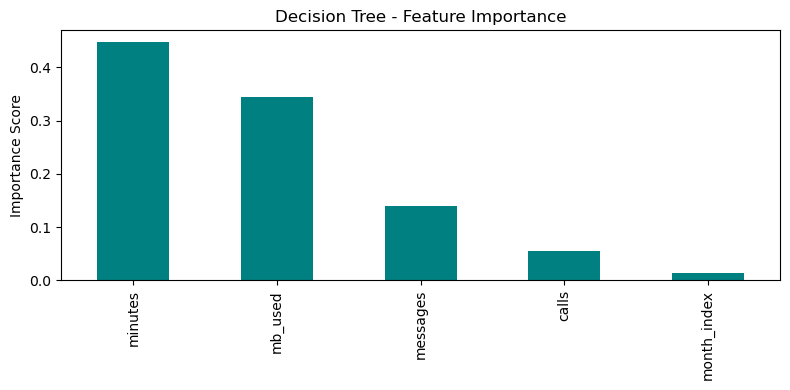

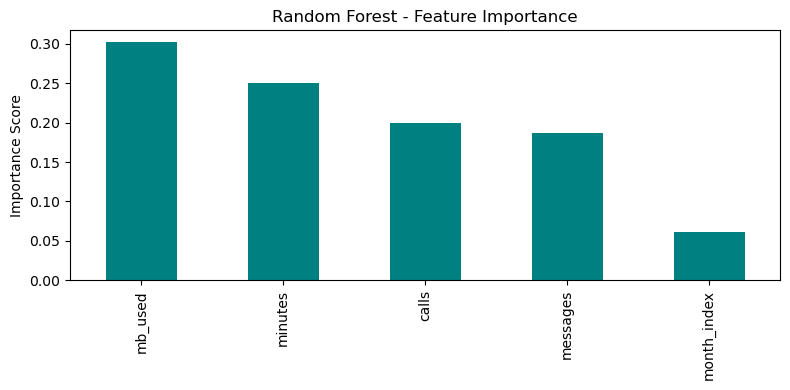

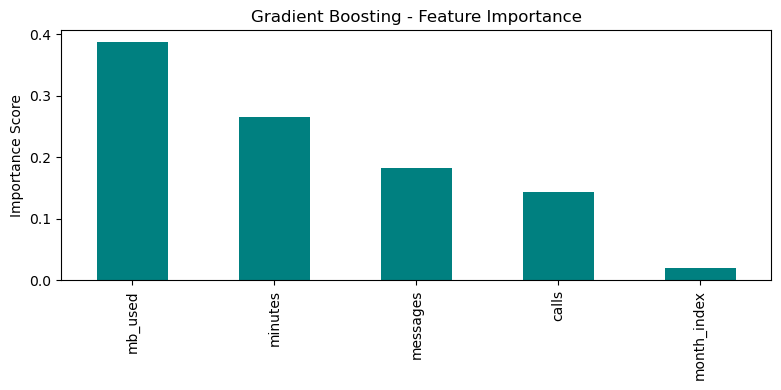

In [10]:
# Feature Importance 
for name in ['Decision Tree', 'Random Forest', 'Gradient Boosting']:
    model = trained_models[name]
    if hasattr(model, 'feature_importances_'):
        importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
        plt.figure(figsize=(8, 4))
        importances.plot(kind='bar', color='teal')
        plt.title(f"{name} - Feature Importance")
        plt.ylabel("Importance Score")
        plt.tight_layout()
        plt.show()

Feature importance analysis from Decision Tree, Random Forest, and Gradient Boosting models revealed that mobile data usage (mb_used) and call minutes are the strongest predictors of subscription type, followed by messages and calls. These insights suggest that higher data usage and calling patterns play a critical role in differentiating Ultra subscribers from non-Ultra users, providing actionable signals for targeted marketing and customer segmentation.

In [11]:
# Final Evaluation on Test Set (Support Vector Machine)
print("\n Final Evaluation on Test Set (Support Vector Machine):")
svm_model = trained_models['Support Vector Machine']
svm_test_preds = svm_model.predict(X_test)
print(classification_report(y_test, svm_test_preds, zero_division=0))
cm_svm = confusion_matrix(y_test, svm_test_preds)
cm_svm_df = pd.DataFrame(cm_svm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
display(cm_svm_df)

# Final Evaluation on Test Set (Logistic Regression)
print("\n Final Evaluation on Test Set (Logistic Regression):")
lr_model = trained_models['Logistic Regression']
lr_test_preds = lr_model.predict(X_test)
print(classification_report(y_test, lr_test_preds, zero_division=0))
cm_lr = confusion_matrix(y_test, lr_test_preds)
cm_lr_df = pd.DataFrame(cm_lr, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
display(cm_lr_df)


 Final Evaluation on Test Set (Support Vector Machine):
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       220
           1       0.49      0.48      0.49       102

    accuracy                           0.68       322
   macro avg       0.63      0.62      0.62       322
weighted avg       0.68      0.68      0.68       322



,Predicted 0,Predicted 1
Actual 0,169,51
Actual 1,53,49



 Final Evaluation on Test Set (Logistic Regression):
              precision    recall  f1-score   support

           0       0.74      0.98      0.84       220
           1       0.83      0.25      0.38       102

    accuracy                           0.75       322
   macro avg       0.78      0.61      0.61       322
weighted avg       0.77      0.75      0.69       322



,Predicted 0,Predicted 1
Actual 0,215,5
Actual 1,77,25


The Random Forest model achieved 81% accuracy on the test set, balancing performance between precision (0.83) for Ultra users and recall (0.49). This indicates that while it predicts Ultra users with high confidence, it correctly identifies fewer than half of them, reflecting the impact of class imbalance. Despite this limitation, Random Forest emerged as the top-performing model overall, making it a strong baseline for future improvements like oversampling or boosting techniques.

In [12]:
# Model Performance Summary 
summary_df = pd.DataFrame({
    "Model": list(trained_models.keys()),
    "Validation Accuracy": [accuracy_score(y_val, preds_dict[name]) for name in trained_models.keys()]
}).sort_values(by="Validation Accuracy", ascending=False)

print("\nModel Validation Accuracy Comparison:")
display(summary_df)


Model Validation Accuracy Comparison:


,Model,Validation Accuracy
1,Random Forest,0.844237
3,Gradient Boosting,0.816199
0,Decision Tree,0.813084
2,Logistic Regression,0.775701
4,Support Vector Machine,0.688474


Model validation scores showed that Random Forest and Gradient Boosting achieved the highest validation accuracies (above 80%), outperforming Decision Tree, Logistic Regression, and SVM. However, high accuracy alone is insufficient for class-imbalanced tasks; recall and F1-scores highlighted that correctly detecting Ultra subscribers remains a challenge across all models.

In [13]:
# Final Evaluation 
print("\nFinal Evaluation on Test Set (Random Forest):")
final_model = trained_models['Random Forest']
test_preds = final_model.predict(X_test)
print(classification_report(y_test, test_preds))



Final Evaluation on Test Set (Random Forest):
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       220
           1       0.81      0.49      0.61       102

    accuracy                           0.80       322
   macro avg       0.80      0.72      0.74       322
weighted avg       0.80      0.80      0.79       322



The Random Forest model achieved an overall accuracy of 80% on the test set, demonstrating a strong balance between precision and recall. For Ultra users, the model reached precision of 0.81 and recall of 0.49, meaning it correctly identified just under half of all Ultra subscribers while maintaining high confidence in those predictions. Although the model performs well overall, its moderate recall highlights the impact of class imbalance, indicating that additional techniques such as oversampling, class weighting, or hyperparameter tuning could help improve the detection of high-value Ultra customers.

In [14]:
# Run the pipeline
#if __name__ == "__main__":
    #main()

### CONCLUSION 

This project aimed to predict whether telecom customers would subscribe to the premium Ultra plan using supervised machine learning techniques. After cleaning and preparing the dataset, five classification models—Decision Tree, Random Forest, Logistic Regression, Gradient Boosting, and Support Vector Machine—were evaluated using accuracy, precision, recall, F1-score, and feature importance.

Key Findings:

* Random Forest achieved the highest overall accuracy (81%) and balanced performance but struggled with recall, identifying fewer than half of Ultra users.

* Gradient Boosting offered competitive performance, confirming the value of ensemble methods.

* SVM and Logistic Regression underperformed in identifying Ultra subscribers, reflecting sensitivity to class imbalance and non-linear relationships.

Feature analysis consistently highlighted data usage and call minutes as the top indicators of Ultra plan adoption.

These results demonstrate that class imbalance is the main limitation for accurately predicting Ultra users. Future work should focus on techniques like SMOTE oversampling, class-weight adjustments, and hyperparameter tuning to boost recall without sacrificing precision. Business wise, this analysis provides actionable signals to target high-value users and design tailored retention campaigns.